In [48]:
from datetime import timedelta, datetime, time, date
import requests
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

In [49]:
datetime.strftime(date.today(), '%Y-%m-%d')

'2023-10-24'

In [50]:
addr = '0xc9becdbc62efb867cb52222b34c187fb170379c6'

end = datetime.strftime(date.today() + timedelta(days=1), '%Y-%m-%d')
start = datetime.strftime(date.today() - timedelta(days=7), '%Y-%m-%d')
timeFrame = 'hour'

u = 'https://api-v2.pendle.finance/core/v2/1/markets/' + addr + '/history?time_frame=' + timeFrame + '&timestamp_start=' + start + '&timestamp_end=' + end

r = requests.get(u)
res = r.json()['results'] # timestamp,  'underlyingInterestApy', 'underlyingRewardApy', 'underlyingApy',
                        # 'impliedApy','ytFloatingApy' ,'ptDiscount'

ts_lst = []
underlyingInterestAPY_lst = []
underlyingRewardAPY_lst = []
underlyingAPY_lst = []
impliedAPY_lst = []
longYieldAPY = []
ptPrice = []
ytPrice = []

for i in range(0, len(res)):
    ts_lst.append(res[i]['timestamp'])
    underlyingInterestAPY_lst.append(res[i]['underlyingInterestApy'])
    underlyingRewardAPY_lst.append(res[i]['underlyingRewardApy'])
    underlyingAPY_lst.append(res[i]['underlyingApy'])
    impliedAPY_lst.append(res[i]['impliedApy'])
    longYieldAPY.append(res[i]['ytFloatingApy'])
    ytPrice.append(res[i]['ptDiscount'])
    ptPrice.append(1.0 - res[i]['ptDiscount'])

In [51]:
with open('pendleData.pkl', 'rb') as fp:
    tmpDict = pickle.load(fp)

util_ts = []
crvUtil = []

for j in tmpDict.keys():
    util_ts.append(datetime.fromtimestamp(tmpDict[j][7]).isoformat())
    crvUtil.append(tmpDict[j][5])

In [52]:
l = len(util_ts)
num_labels = 9
div = math.floor((l - 2) / num_labels)

util_ts_labels = []
util_ts_labels.append(util_ts[0])
for k in range(1, num_labels):
    idx = k * div
    util_ts_labels.append(util_ts[idx])

util_ts_labels.append(util_ts[l - 1])

# util_ts_labels

In [53]:
def avg_lst(lst):
    return sum(lst) / len(lst)

avg_crv_util = avg_lst(crvUtil)

def median_lst(lst):
    test_lst = lst.copy()
    test_lst.sort()
    mid = len(test_lst) // 2
    res = (test_lst[mid] + test_lst[~mid]) / 2

    return res

median_crv_util = median_lst(crvUtil)

In [54]:
def time_diff(lst):
    strt = datetime.fromisoformat(lst[0])
    end = datetime.fromisoformat(lst[len(lst) - 1])
    return (end - strt).total_seconds()

util_ts_1 = []
for ts in util_ts:
    util_ts_1.append(str(ts))

diff = time_diff(util_ts_1)

secs_in_day = 86400
days = diff / secs_in_day
buckets = math.ceil(days)

bucket_diff = diff / 2

util_secs = []
for x in util_ts:
    conv = datetime.fromisoformat(str(x)) - datetime(1900,1,1)
    s = conv.total_seconds()
    util_secs.append(s)

tsdf = pd.DataFrame({
    'ts': util_secs,
    'util': crvUtil
})

tsdf_1 = tsdf.loc[tsdf['ts'] <= (util_secs[0] + bucket_diff)]

tsdf_2 = tsdf.loc[tsdf['ts'] >= (util_secs[0] + bucket_diff)]

avg_df_1 = avg_lst(tsdf_1['util'])
avg_df_2 = avg_lst(tsdf_2['util'])

In [55]:
util_ts_labels_sh = []
for val in util_ts_labels:
    util_ts_labels_sh.append(val[0:10] + '\n' + val[11:16])

In [56]:
sns.set_theme()
sns.set_style()

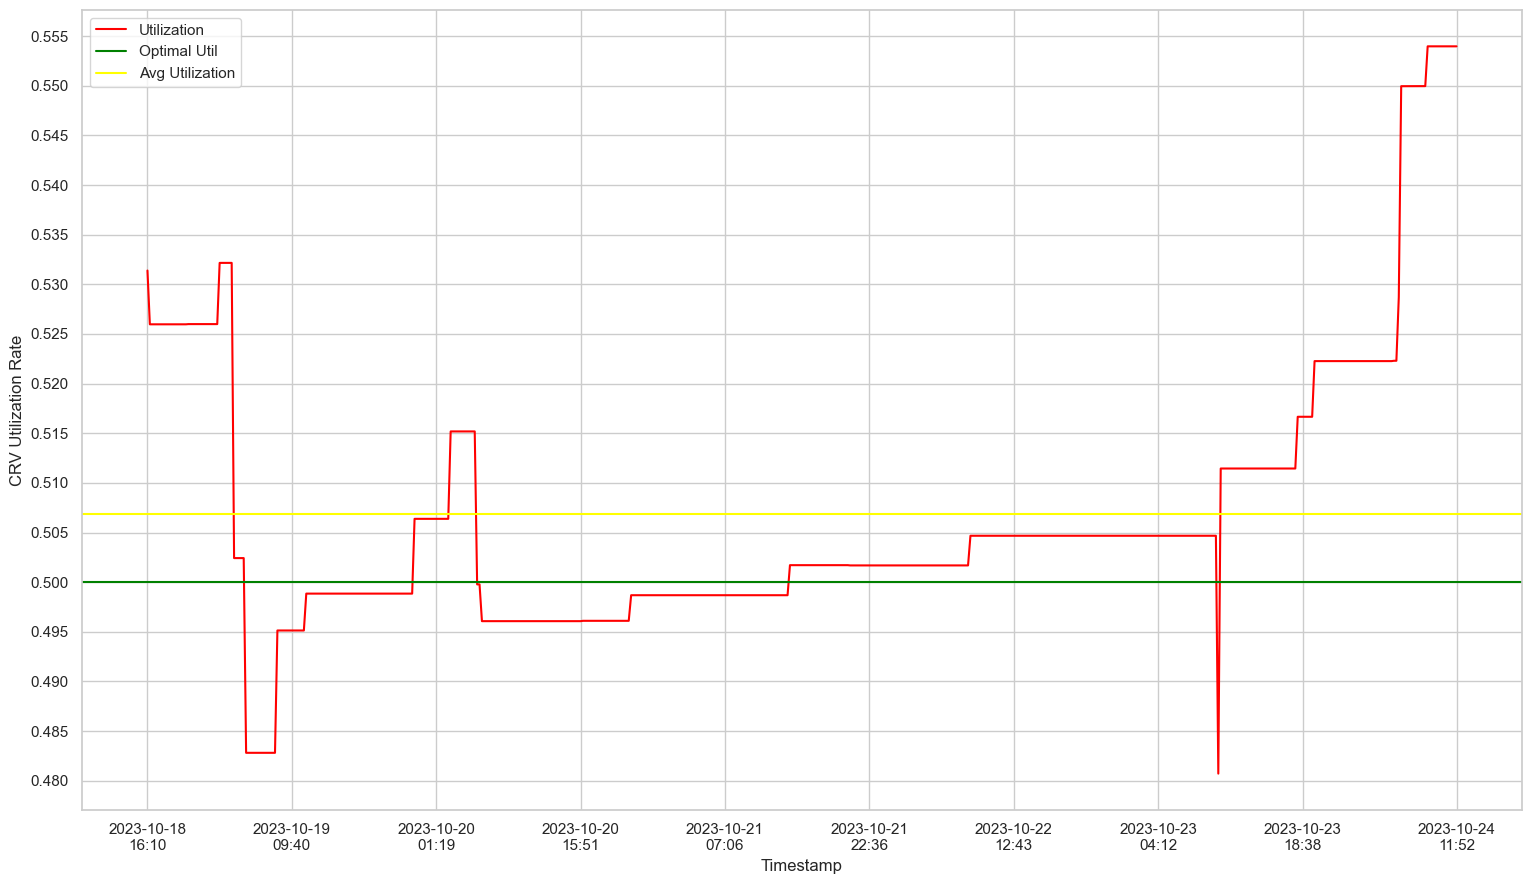

In [58]:
sns.set_style('whitegrid')

rng_fmt = []
rng = pd.date_range(start= util_ts[0], end=util_ts[len(util_ts) - 1], periods=12)
for val in util_ts_labels:
    rng_fmt.append(val[0:10] + '\n' + val[11:16])
# u = np.empty(len(util_ts))
# u.fill(uopt)
# a = np.empty(len(util_ts))
# a.fill(avg_crv_util)
#
# util_df['Util Optimal'] = u
# util_df['Avg Util'] = a
#
#
# sns.lineplot(util_df, palette='Spectral', linewidth=1)


fig = plt.figure(figsize=(18,10))

uopt = 0.50

ax = fig.add_axes([0.1,0.1,0.8,0.8])

ax.plot(util_ts, crvUtil, color='red')

ax.set_xticks(util_ts_labels)

ax.set_xticklabels(rng_fmt)

s, e = ax.get_ylim()
ax.set_yticks(np.arange(round(s, 2),e ,0.005))

plt.axhline(y = uopt, color = 'green', linestyle = '-')
plt.axhline(y = avg_crv_util, color = 'yellow', linestyle = '-')

plt.xlabel('Timestamp')
plt.ylabel('CRV Utilization Rate')

ax.legend(['Utilization', 'Optimal Util', 'Avg Utilization'])

plt.show()

In [20]:
# impliedAPY_lst
# longYieldAPY
# ptPrice
# ytPrice
#ts_lst

d = {
    'Timestamp': ts_lst,
    'Implied APY': impliedAPY_lst,
    'Underlying APY': underlyingAPY_lst,
    'LongYield APY': longYieldAPY,
    'PT Px': ptPrice,
    'YT Px': ytPrice
}

df = pd.DataFrame(d)

DeltaGenerator()

In [12]:
def ts_labels_pick(ts):
    l = len(ts)
    num_labels = 9
    div = math.floor((l - 2) / num_labels)

    util_ts_labels = []
    util_ts_labels.append(ts[0])
    for k in range(1, num_labels):
        idx = k * div
        util_ts_labels.append(ts[idx])

    util_ts_labels.append(ts[l - 1])
    return util_ts_labels

new_labels = ts_labels_pick(df['Timestamp'])

def ts_labels(ts):
    util_ts_labels_sh = []
    for val in ts:
        util_ts_labels_sh.append(val[0:10] + '\n' + val[11:16])
    return util_ts_labels_sh

new_labels_final = ts_labels(new_labels)

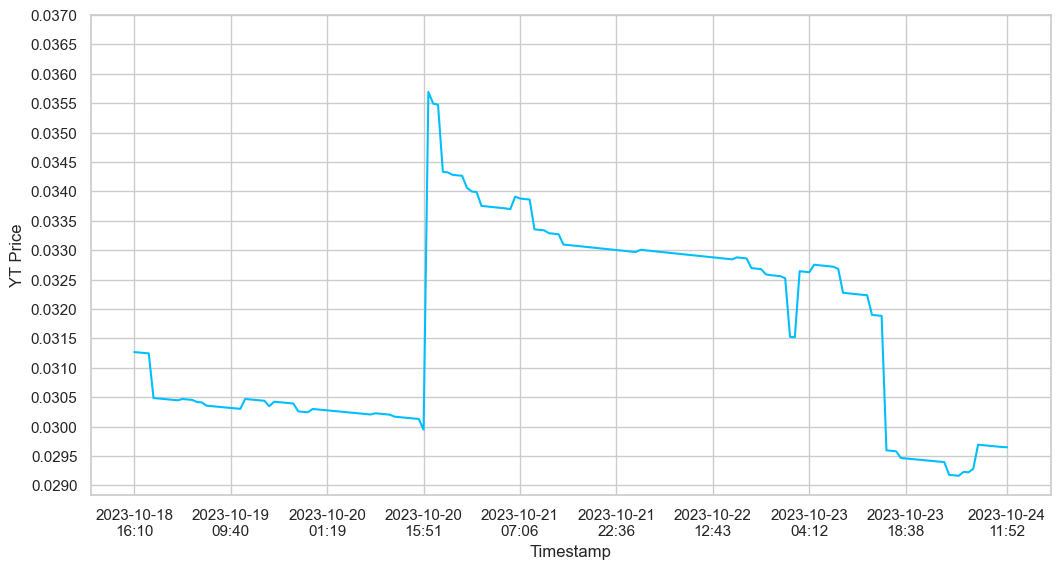

In [65]:
sns.set_style('whitegrid')

fig1 = plt.figure(figsize=(12,6))

ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])

len_df = len(df['Timestamp'])

rng_ts = pd.date_range(start= df['Timestamp'][0], end=df['Timestamp'][len_df - 1], periods=12)
rng_ts_fmt = []
for val in util_ts_labels:
    rng_ts_fmt.append(val[0:10] + '\n' + val[11:16])

# ax1.plot(df['Timestamp'], df['PT Px'], color='red')
ax1.plot(df['Timestamp'], df['YT Px'], color='deepskyblue')

s, e = ax1.get_ylim()
ax1.set_yticks(np.arange(round(s, 2) - 0.001,e + 0.001,0.0005))


plt.xticks(new_labels, rng_ts_fmt)

plt.xlabel('Timestamp')
plt.ylabel('YT Price')

plt.show()

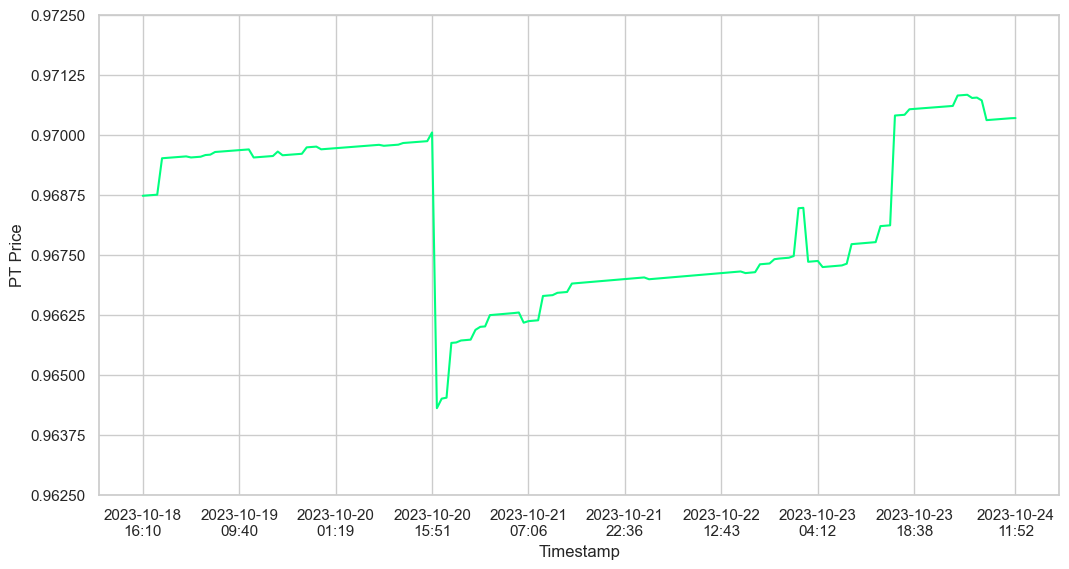

In [69]:
sns.set_style('whitegrid')

fig1 = plt.figure(figsize=(12,6))

ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])

# ax1.plot(df['Timestamp'], df['PT Px'], color='red')
ax1.plot(df['Timestamp'], df['PT Px'], color='springgreen')

s, e = ax1.get_ylim()
ax1.set_yticks(np.arange(round(s, 2) + 0.0025,e + 0.0025,0.00125))


plt.xticks(new_labels, rng_ts_fmt)

plt.xlabel('Timestamp')
plt.ylabel('PT Price')

plt.show()

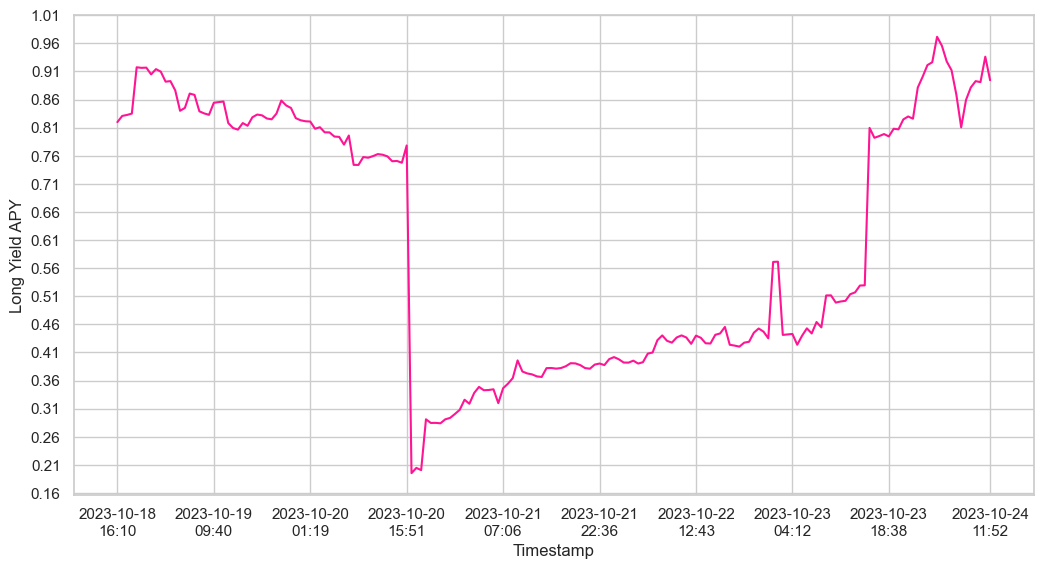

In [70]:
sns.set_style('whitegrid')

fig1 = plt.figure(figsize=(12,6))

ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])

# ax1.plot(df['Timestamp'], df['PT Px'], color='red')
ax1.plot(df['Timestamp'], df['LongYield APY'], color='deeppink')

s, e = ax1.get_ylim()
ax1.set_yticks(np.arange(round(s, 2),e,0.05))


plt.xticks(new_labels, rng_ts_fmt)

plt.xlabel('Timestamp')
plt.ylabel('Long Yield APY')

plt.show()

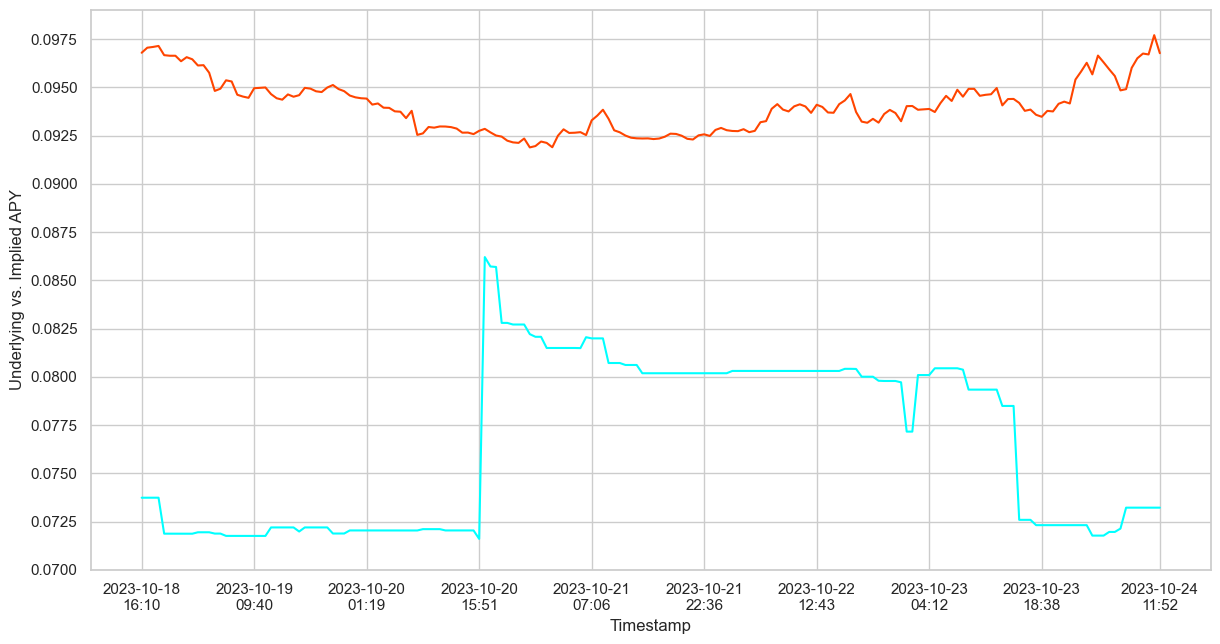

In [73]:
sns.set_style('whitegrid')

fig1 = plt.figure(figsize=(14,7))

ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])

# ax1.plot(df['Timestamp'], df['PT Px'], color='red')
ax1.plot(df['Timestamp'], df['Underlying APY'], color='orangered')
ax1.plot(df['Timestamp'], df['Implied APY'], color='cyan')



s, e = ax1.get_ylim()
ax1.set_yticks(np.arange(round(s, 2),e,0.0025))


plt.xticks(new_labels, rng_ts_fmt)

plt.xlabel('Timestamp')
plt.ylabel('Underlying vs. Implied APY')

plt.show()